In [1]:
%load_ext autoreload
%autoreload 2

from webbrowser import get
import pandas as pd
from sklearn.metrics import accuracy_score, r2_score
from models import *
import logging
from pretty_logger import get_logger
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(datafile)
df["date"] = pd.to_datetime(df["day_survey"])
df["C"] = df["date"].apply(
    lambda date: (
        COVIDStatus.POST_COVID if date > date_covid else COVIDStatus.PRE_COVID
    )
)

df_head = df.head(5).copy()

df.rename(columns=reverse_ema_dictionary, inplace=True)
df.set_index(["uid", "date"], inplace=True)
len_before_drop_na = len(df)
df.dropna(subset=ema + physical + social, inplace=True)
# df.dropna(subset=ema, inplace=True)

len_after_drop_na = len(df)
print(
    f"Length before dropna: {len_before_drop_na}\n"
    f"Length a dropna: {len_after_drop_na}"
)

sets_df = pd.read_parquet(sets_file, engine="pyarrow")

Length before dropna: 34706
Length a dropna: 16311


In [4]:
# GAD2 > 3
# https://www.hiv.uw.edu/page/mental-health-screening/gad-2
(df["Y4"] > 3).sum() / len(df)

0.07491876647661087

In [5]:
# PHQ2 > 3
# https://www.hiv.uw.edu/page/mental-health-screening/phq-2
precovid_phq2_greater_than_3 = (
    df[df["C"] == COVIDStatus.PRE_COVID]["Y2"] > 3
).sum() / len(df)

postcovid_phq2_greater_than_3 = (
    df[df["C"] == COVIDStatus.POST_COVID]["Y2"] > 3
).sum() / len(df)

print(f"PHQ2 greater than 3 in precovid: {precovid_phq2_greater_than_3}")
print(f"PHQ2 greater than 3 in postcovid: {postcovid_phq2_greater_than_3}")

PHQ2 greater than 3 in precovid: 0.22070995034026117
PHQ2 greater than 3 in postcovid: 0.05395132119428606


In [6]:
df[df["C"] == COVIDStatus.POST_COVID]["Y2"].describe()

count    2844.000000
mean        2.614627
std         2.734058
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        12.000000
Name: Y2, dtype: float64

In [7]:
def pre_and_post_distributions(df: pd.DataFrame, column: str):
    colorpre = "green"
    colorpost = "orangered"
    nbins = 6
    alpha = 0.4
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(
        df[df["C"] == COVIDStatus.POST_COVID][column],
        bins=nbins,
        edgecolor="k",
        alpha=alpha,
        color=colorpost,
        label="postcovid",
        stat="probability",
        ax=ax,
    )
    sns.histplot(
        df[df["C"] == COVIDStatus.PRE_COVID][column],
        bins=nbins,
        edgecolor="k",
        alpha=alpha,
        color=colorpre,
        label="precovid",
        stat="probability",
        ax=ax,
    )
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.legend()
    fig.suptitle(f"{column}={full_dictionary[column]}")

    fig.savefig(Path(project_root, "temp", f"Pre_and_post_{column}.png"))
    fig.savefig(Path(project_root, "temp", f"Pre_and_post_{column}.svg"))
    plt.close(fig)
    return ax

In [8]:
# PHQ4 > 6
# https://www.oregonpainguidance.org/app/content/uploads/2016/05/PHQ-4.pdf
# PHQ2 > 3
# https://www.hiv.uw.edu/page/mental-health-screening/phq-2
precovid_phq4_greater_than_6 = (
    df[df["C"] == COVIDStatus.PRE_COVID]["Y3"] > 6
).sum() / len(df)

postcovid_phq4_greater_than_6 = (
    df[df["C"] == COVIDStatus.POST_COVID]["Y3"] > 6
).sum() / len(df)

print(f"PHQ4 greater than 6 in precovid: {precovid_phq4_greater_than_6}")
print(f"PHQ4 greater than 6 in postcovid: {postcovid_phq4_greater_than_6}")

PHQ4 greater than 6 in precovid: 0.0
PHQ4 greater than 6 in postcovid: 0.0


In [9]:
mean_precovid_phq4 = df[df["C"] == COVIDStatus.PRE_COVID]["Y3"].mean()
mean_postcovid_phq4 = df[df["C"] == COVIDStatus.POST_COVID]["Y3"].mean()
print(
    f"precovid mean phq4: {mean_precovid_phq4}"
    f"postcovid mean phq4: {mean_postcovid_phq4}"
)

precovid mean phq4: 1.28610677953516postcovid mean phq4: 1.3716596343178622


In [10]:
mean_precovid_phq2 = df[df["C"] == COVIDStatus.PRE_COVID]["Y2"].mean()
mean_postcovid_phq2 = df[df["C"] == COVIDStatus.POST_COVID]["Y2"].mean()
print(
    f"precovid mean phq2: {mean_precovid_phq2}"
    f"postcovid mean phq2: {mean_postcovid_phq2}"
)

precovid mean phq2: 2.2610826464691467postcovid mean phq2: 2.6146272855133614


FileNotFoundError: [Errno 2] No such file or directory: '/home/matthieu/workspace/566well-being/temp/Pre_and_post_Y1.png'

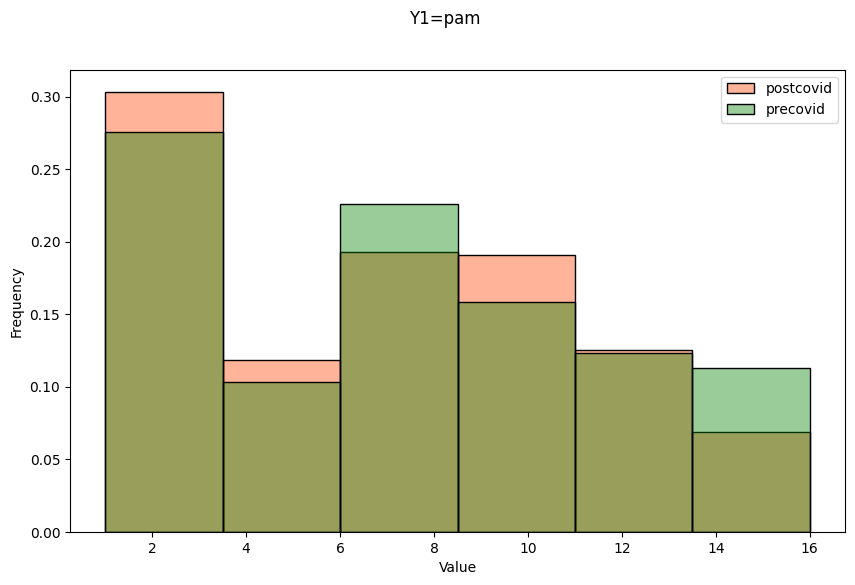

In [11]:
for col in ema_dictionary.keys():
    pre_and_post_distributions(df, col)

In [ ]:
for column in social + physical + ema + sleep:
    mean = df[column].mean()
    print(f"Mean of {column}:{full_dictionary[column]}={mean:.3f}")

Mean of S1:traveling=1577.529
Mean of S2:distance traveled=123422.310
Mean of S3:time in social location=1.684
Mean of S4:visits=4.681
Mean of S5:duration unlocked phone in social locations=12.507
Mean of S6:frequency of unlocked phone in social locations=10.399
Mean of S7:motion at social locations=60.427
Mean of P1:excercise=9789.249
Mean of P2:studying=3.368
Mean of P3:in house=11.030
Mean of P4:sports=0.321
Mean of Y1:pam=7.320
Mean of Y2:phq4_score=2.323
Mean of Y3:phq2_score=1.301
Mean of Y4:gad2_score=1.021
Mean of Y5:social_level=3.131
Mean of Y6:sse_score=12.915
Mean of Y7:stress=2.599
Mean of Z1:sleep_duration=7.114
Mean of Z2:sleep start time=42.404
Mean of Z3:sleep end time=99.315


In [ ]:
for column in df.columns:
    if column in full_dictionary.keys():
        print(
            f"{column}:{full_dictionary[column]}:\n{df.describe()[column]}\n-----------------\n"
        )

Y1:pam:
count    16311.000000
mean         7.319968
std          4.402365
min          1.000000
25%          3.000000
50%          7.000000
75%         10.000000
max         16.000000
Name: Y1, dtype: float64
-----------------

Y2:phq4_score:
count    16311.000000
mean         2.322727
std          2.537266
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         12.000000
Name: Y2, dtype: float64
-----------------

Y3:phq2_score:
count    16311.000000
mean         1.301024
std          1.382557
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: Y3, dtype: float64
-----------------

Y4:gad2_score:
count    16311.000000
mean         1.021029
std          1.406776
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          6.000000
Name: Y4, dtype: float64
-----------------

Y5:social_level:
count    16311.000000
mean         3.130709
std   

KeyError: 'C'

In [ ]:
df.describe()["P1"]